In [1]:
#%matplotlib inline
#!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/module-examples/scatterers_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# deeptrack.scatterers

This example introduces the module deeptrack.scatterers - but only for the cases when using the Rayleigh-Gans approximation of the scatterer.

## What is a scatterer?

Scatterers are implementations of the abstract class `Feature` that represent scattering objects (see also [features_example](features_example.ipynb)). When calculating the scattered field, they are discretized into voxels.

All physcial properties of scatterers are given in SI units, unless otherwise stated. In particular, the position of a scatterer is measured from the top left corner of the image and can either be given in meters (default) or pixels by setting the property `position_unit` to `"meter"` or `"pixel"`. The z-position of the particle can either be set as the the third element of the property `position`, or as the property `z`. The calculation of a scatterer is automatically upsampled using the `upsample` property.

All scatterers need a reference to the optical system through which they are viewed in order to calculate scale factors. This is achieved by calling an optical device from the `optics` module (see also [optics_example](optics_example.ipynb)) with the scatterer. For more information about deeptrack.scatterers (see also [deeptrack_scatterers](deeptrack_scatterers.ipynb))


### What is a Rayleigh-Gans scattering theory?

The Rayleigh-Gans approximate is an approximate solution to light scattering by optically soft particles. Optical softness implies that the relative refractive index of particle is close to that of the surrounding medium. The approximation holds for particles of arbitrary shape that are relatively small but can be larger than Rayleigh scattering limits. As of now, implementation is of spheres and/or aggregates of spheres, as it exists an explicit formula for such shapes.


As long as a particle fulfills the criteria of the Rayleigh-Debye-Gans approximations, the expected particle signal from a specific size and refractive index distribution is given by the polarizability $\alpha$ and the particle form factor $f(\theta,\Phi)$. In general the scattered light is computed by

\begin{align*}
    &S = \frac{3i * k^{3}}{2\pi} K V f(\theta,\Phi)\\

    &S_1 = S \\

    &S_2 = S * \cos(\theta)
\end{align*}

where $\theta$ and $\Phi$ are the angles describing the direction of the incoming and scattered light, $k$ the wavevector, $K$ the Claussius-Massotti relation, $V$ the volume and $f(\theta,\Phi)$ the form factor.



Additionally, a parameter called `backscatter` has been implemeted which sets in which direction to calculate the scattered field.

## 1. Setup

Imports the objects needed for this example.

In [2]:
%matplotlib inline
import sys
sys.path.insert(0, "../..") # Adds the module to path

import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt


import scipy.io as IO

IMAGE_SIZE = 64

c:\Users\Fredrik\Documents\GitHub\DeepTrack-2.0\examples\module-examples\../..\deeptrack\scatterers.py:99: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if upsample is not 1:  # noqa: F632


We create a optical device `optics` to view scatterers through, in this case a brightfield microscope implemented by `Brightfield`.

In [3]:
#Define the optics. 
optics = dt.Brightfield(
    NA=1,
    resolution=1.13e-6,
    wavelength=650e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    backscatter=True, #If backscatter true, then we compute the scatters in that direction. Standard is False.
)

In [4]:
def func():
    def inner(image):
        image = image - 1
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

complex_to_float = dt.Lambda(func)

In [5]:
n_examples = 2

## 2. RayleighGans approximation for a sphere and spherical shell.

Analytical solutions to the form factor can be attained for some specific geometries such as spheres and core-shell spheres.

For a spherical particle the form factor is defined as,
\begin{equation*}
    f_{sphere}(\theta)=\frac{3}{(qR)^3}\Big(\sin(qR)-qR\cos(qR)\Big),~q=\frac{4\pi n_m}{\lambda}\sin(\theta/2)
\end{equation*}

and for a core-shell sphere defined as,

\begin{equation*}
    f_{shell}(\theta)=\frac{\sin(qR)}{qR}.
\end{equation*}
Thus, when $\theta\neq 0$ the scattering signal depend on the mass distribution within the particle.


Down below, we use these analytical expressions to simulate the approximations for spheres and core-shell spheres.

### 2.1 Sphere

In [6]:
#We define a sphere.

particle_sphere = dt.RayleighGansSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + 4 * np.random.choice([-1, 1], 2) * np.random.rand(),
    z=lambda: 0,
    radius=lambda:5e-8 + 1e-7 * np.random.rand(),
    refractive_index=lambda: 1.37 + 0.1*np.random.rand(),
    position_unit="pixel",
    refractive_index_medium=1.33,
)

In [7]:
rayleighgan_sphere = optics(particle_sphere) >> complex_to_float

Radius = 71.7 nm
Refractive Index = 1.46
Position = [29.8 29.8]


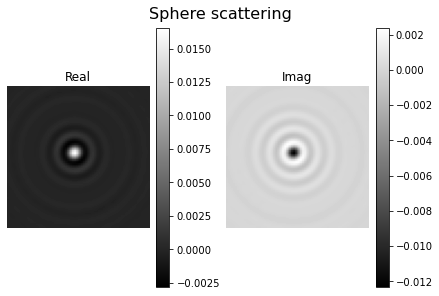

Radius = 126.5 nm
Refractive Index = 1.39
Position = [28.8 28.8]


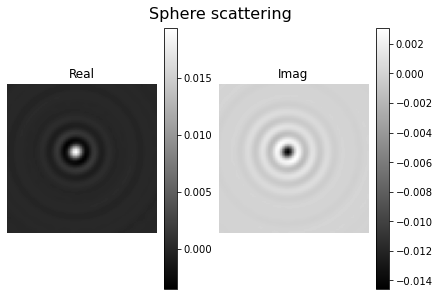

In [8]:
for _ in range(n_examples):
    image = rayleighgan_sphere.update().resolve()

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout = True)
    fig.suptitle('Sphere scattering', fontsize=16)

    #Titles
    axs[0].set_title('Real')
    axs[1].set_title('Imag')

    im = axs[0].imshow(image[:, :, 0], cmap="gray")
    axs[0].axis('off')

    im2 = axs[1].imshow(image[:, :, 1], cmap="gray")
    axs[1].axis('off')

    plt.colorbar(im, ax=axs[0])
    plt.colorbar(im2, ax=axs[1])

    radius = image.get_property('radius')
    ri = image.get_property('refractive_index')
    position = image.get_property('position')

    print(f"Radius = {np.round(radius /1e-9, 1)} nm")
    print(f"Refractive Index = {np.round(ri, 2)}")
    print(f"Position = {np.round(position, 1)}")

    plt.show()

### 2.2 Spherical shell

In [9]:
#We define a spherical shell.

particle_sphericalshell = dt.RayleighGansSphericalShell(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + 4 * np.random.choice([-1, 1], 2) * np.random.rand(),
    z=lambda: 0,
    radius=lambda:5e-8 + 1e-7 * np.random.rand(),
    refractive_index=lambda: 1.37 + 0.1*np.random.rand(),
    position_unit="pixel",
    refractive_index_medium=1.33,
)

In [10]:
rayleighgan_sphericalshell = optics(particle_sphericalshell) >> complex_to_float

Radius = 77.4 nm
Refractive Index = 1.46
Position = [33.3 33.3]


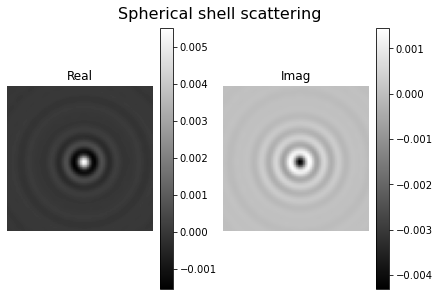

Radius = 126.3 nm
Refractive Index = 1.43
Position = [30.3 33.7]


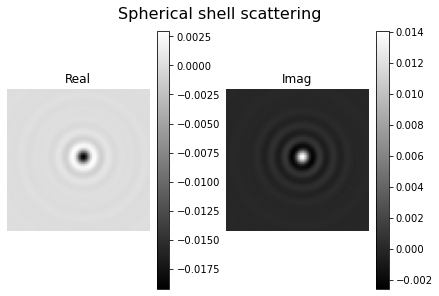

In [11]:
for _ in range(n_examples):
    image = rayleighgan_sphericalshell.update().resolve()

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout = True)
    fig.suptitle('Spherical shell scattering', fontsize=16)

    #Titles
    axs[0].set_title('Real')
    axs[1].set_title('Imag')

    im = axs[0].imshow(image[:, :, 0], cmap="gray")
    axs[0].axis('off')

    im2 = axs[1].imshow(image[:, :, 1], cmap="gray")
    axs[1].axis('off')

    plt.colorbar(im, ax=axs[0])
    plt.colorbar(im2, ax=axs[1])

    radius = image.get_property('radius')
    ri = image.get_property('refractive_index')
    position = image.get_property('position')

    print(f"Radius = {np.round(radius /1e-9, 1)} nm")
    print(f"Refractive Index = {np.round(ri, 2)}")
    print(f"Position = {np.round(position, 1)}")

    plt.show()

## 3. Dimer of two spheres

In [12]:
particle_dimer = dt.RayleighGansAggregateSpheres(
    radius=lambda: 5e-8 + 1e-7 * np.random.rand(2), # 50 - 200 radie
    refractive_index=lambda: 1.37 + 0.1*np.random.rand(2),
    position_simulation_case = "side_by_side_spheres",
    position_unit="pixel",
    refractive_index_medium=1.33,
    xy_offset_range = [10, 10], #Within wich region of the center to place the aggregate
    zrange = [-1e-6, 1e-6] #The range of which z varies in mikrometer.
)

In [13]:
rayleighgan_dimer = optics(particle_dimer) >> complex_to_float

Radius = [140.7 103.9] nm
Refractive Index = [1.4, 1.46]


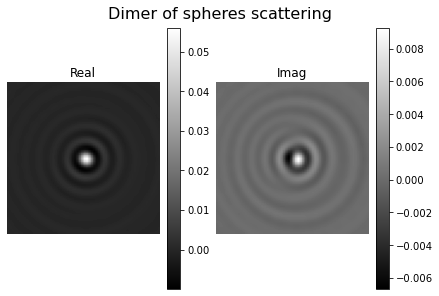

Radius = [78.  58.5] nm
Refractive Index = [1.44, 1.41]


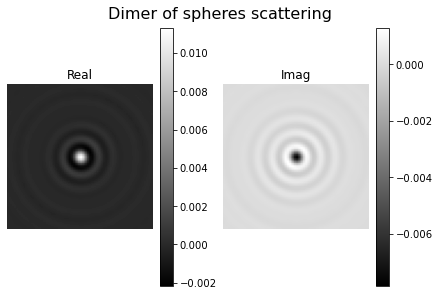

In [14]:
for _ in range(n_examples):
    image = rayleighgan_dimer.update().resolve()

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout = True)
    fig.suptitle('Dimer of spheres scattering', fontsize=16)

    #Titles
    axs[0].set_title('Real')
    axs[1].set_title('Imag')

    im = axs[0].imshow(image[:, :, 0], cmap="gray")
    axs[0].axis('off')

    im2 = axs[1].imshow(image[:, :, 1], cmap="gray")
    axs[1].axis('off')

    plt.colorbar(im, ax=axs[0])
    plt.colorbar(im2, ax=axs[1])

    radius = image.get_property('radius')
    ri = image.get_property('refractive_index')
    position = image.get_property('position')

    print(f"Radius = {np.round(radius /1e-9, 1)} nm")
    print(f"Refractive Index = {[np.round(r, 2) for r in ri]}")
    plt.show()

## 4. Aggregate of 3 - 10 spheres.

### 4.1  Aggregates 
Lets now simulate aggregates of n spheres. At least one sphere is connected to another, and they do not overlap. As of now, we limit ourselves to aggregates containing 3-10 particles.

In [15]:
n_aggs = 5

particle_agg5 = dt.RayleighGansAggregateSpheres(
    radius=lambda: 5e-8 + 1e-7 * np.random.rand(n_aggs), # 50 - 200 radie
    refractive_index=lambda: 1.37 + 0.1*np.random.rand(n_aggs),
    position_simulation_case = "small_packing_off_spheres",
    position_unit="pixel",
    refractive_index_medium=1.33,
    xy_offset_range = [10, 10], #Within wich region of the center to place the aggregate
    zrange = [-1e-6, 1e-6] #The range of which z varies in mikrometer.
)

n_agg = 10
particle_agg10 = dt.RayleighGansAggregateSpheres(
    radius=lambda: 5e-8 + 1e-7 * np.random.rand(n_agg), # 50 - 200 radie
    refractive_index=lambda: 1.37 + 0.1*np.random.rand(n_agg),
    position_simulation_case = "small_packing_off_spheres",
    position_unit="pixel",
    refractive_index_medium=1.33,
    xy_offset_range = [10, 10], #Within wich region of the center to place the aggregate
    zrange = [-1e-6, 1e-6] #The range of which z varies in mikrometer.
)


In [16]:
rayleighgan_agg5 = optics(particle_agg5) >> complex_to_float
rayleighgan_agg10 = optics(particle_agg10) >> complex_to_float

Radius = [127.3 105.7  76.   61.  134.1] nm
Refractive Index = [1.41, 1.38, 1.38, 1.47, 1.45]


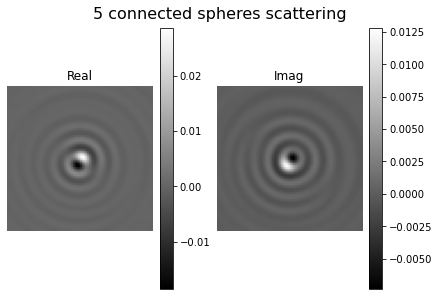

Radius = [ 53.8 113.8  75.9 124.3 128. ] nm
Refractive Index = [1.42, 1.41, 1.42, 1.43, 1.47]


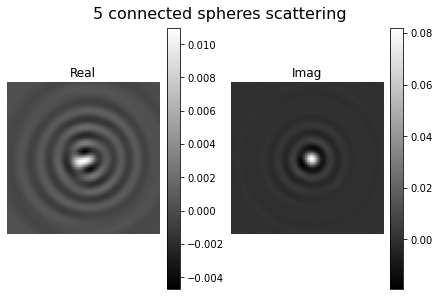

In [17]:
for _ in range(n_examples):
    image = rayleighgan_agg5.update().resolve()

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout = True)
    fig.suptitle('5 connected spheres scattering', fontsize=16)

    #Titles
    axs[0].set_title('Real')
    axs[1].set_title('Imag')

    im = axs[0].imshow(image[:, :, 0], cmap="gray")
    axs[0].axis('off')

    im2 = axs[1].imshow(image[:, :, 1], cmap="gray")
    axs[1].axis('off')

    plt.colorbar(im, ax=axs[0])
    plt.colorbar(im2, ax=axs[1])

    radius = image.get_property('radius')
    ri = image.get_property('refractive_index')
    #position = image.get_property('position')

    print(f"Radius = {np.round(radius /1e-9, 1)} nm")
    print(f"Refractive Index = {[np.round(r, 2) for r in ri]}")
    plt.show()

Radius = [125.5  98.9  75.6 133.1 131.5 132.7 106.5  57.2  70.5  65.5] nm
Refractive Index = [1.38, 1.47, 1.39, 1.43, 1.41, 1.42, 1.46, 1.47, 1.47, 1.45]


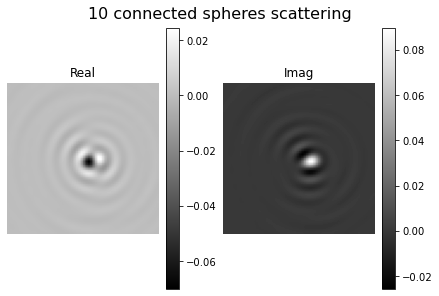

Radius = [134.8 108.9  65.1  62.1 110.4  69.5  69.1 127.7 106.   85.6] nm
Refractive Index = [1.44, 1.41, 1.44, 1.45, 1.38, 1.44, 1.39, 1.44, 1.41, 1.37]


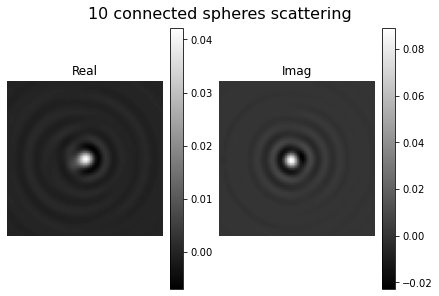

In [18]:
for _ in range(n_examples):
    image = rayleighgan_agg10.update().resolve()

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout = True)
    fig.suptitle('10 connected spheres scattering', fontsize=16)

    #Titles
    axs[0].set_title('Real')
    axs[1].set_title('Imag')

    im = axs[0].imshow(image[:, :, 0], cmap="gray")
    axs[0].axis('off')

    im2 = axs[1].imshow(image[:, :, 1], cmap="gray")
    axs[1].axis('off')

    plt.colorbar(im, ax=axs[0])
    plt.colorbar(im2, ax=axs[1])

    radius = image.get_property('radius')
    ri = image.get_property('refractive_index')
    #position = image.get_property('position')

    print(f"Radius = {np.round(radius /1e-9, 1)} nm")
    print(f"Refractive Index = {[np.round(r, 2) for r in ri]}")
    plt.show()

### 4.2 Randomly placing the spheres to form aggregates. 

In [19]:
n_aggs = 5

particle_agg5r = dt.RayleighGansAggregateSpheres(
    radius=lambda: 5e-8 + 1e-7 * np.random.rand(n_aggs), # 50 - 200 radie
    refractive_index=lambda: 1.37 + 0.1*np.random.rand(n_aggs),
    position_simulation_case = "random",
    position_unit="pixel",
    refractive_index_medium=1.33,
    xy_offset_range = [10, 10], #Within wich region of the center to place the aggregate
    zrange = [-1e-6, 1e-6] #The range of which z varies in mikrometer.
)

n_agg = 10
particle_agg10r = dt.RayleighGansAggregateSpheres(
    radius=lambda: 5e-8 + 1e-7 * np.random.rand(n_agg), # 50 - 200 radie
    refractive_index=lambda: 1.37 + 0.1*np.random.rand(n_agg),
    position_simulation_case = "random",
    position_unit="pixel",
    refractive_index_medium=1.33,
    xy_offset_range = [10, 10], #Within wich region of the center to place the aggregate
    zrange = [-1e-6, 1e-6] #The range of which z varies in mikrometer.
)

In [20]:
rayleighgan_agg5r = optics(particle_agg5r) >> complex_to_float
rayleighgan_agg10r = optics(particle_agg10r) >> complex_to_float

Radius = [ 95.6 101.5  66.4  70.1 109.1] nm
Refractive Index = [1.45, 1.4, 1.43, 1.46, 1.44]


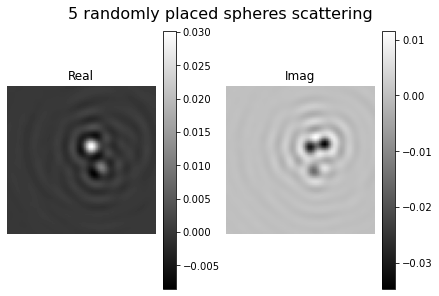

Radius = [115.9 147.2  77.7  99.4  84.5] nm
Refractive Index = [1.37, 1.45, 1.39, 1.4, 1.45]


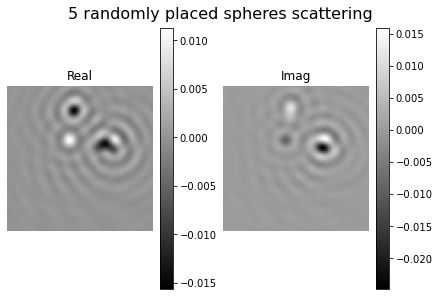

In [21]:
for _ in range(n_examples):
    image = rayleighgan_agg5r.update().resolve()

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout = True)
    fig.suptitle('5 randomly placed spheres scattering', fontsize=16)

    #Titles
    axs[0].set_title('Real')
    axs[1].set_title('Imag')

    im = axs[0].imshow(image[:, :, 0], cmap="gray")
    axs[0].axis('off')

    im2 = axs[1].imshow(image[:, :, 1], cmap="gray")
    axs[1].axis('off')

    plt.colorbar(im, ax=axs[0])
    plt.colorbar(im2, ax=axs[1])

    radius = image.get_property('radius')
    ri = image.get_property('refractive_index')
    #position = image.get_property('position')

    print(f"Radius = {np.round(radius / 1e-9, 1)} nm")
    print(f"Refractive Index = {[np.round(r, 2) for r in ri]}")
    plt.show()

## 5. Comparing the scattering between two silica spheres of different sizes



In [22]:
#Spherical particle with refractive index of 1.42 and radius 190nm
particle_sphere_190 = dt.RayleighGansSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2),
    z=lambda: 0,
    radius=lambda:1.9e-7, #190nm
    refractive_index=lambda: (1.42),
    position_unit="pixel",
    refractive_index_medium=1.33,
)

#Spherical particle with refractive index of 1.42 and radius 150nm
particle_sphere_150 = dt.RayleighGansSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2),
    z=lambda: 0,
    radius=lambda:1.5e-7, #150nm
    refractive_index=lambda: (1.42),
    position_unit="pixel",
    refractive_index_medium=1.33,
)

In [23]:
s150 = optics(particle_sphere_150) >> complex_to_float
s190 = optics(particle_sphere_190) >> complex_to_float

In [24]:
s150 =s150.update().resolve()
s190 =s190.update().resolve()

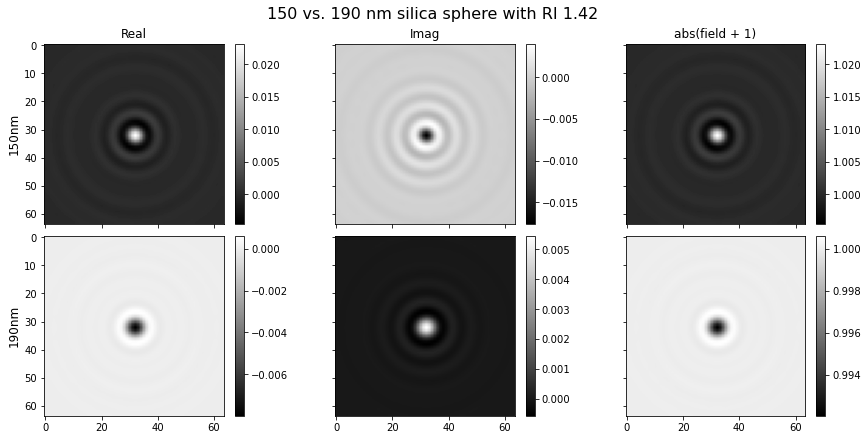

In [25]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, constrained_layout = True, figsize=(12,6))
fig.suptitle('150 vs. 190 nm silica sphere with RI 1.42', fontsize=16)

#Titles
axs[0, 0].set_title('Real', fontsize = 12)
axs[0, 1].set_title('Imag', fontsize = 12)
axs[0, 2].set_title('abs(field + 1)', fontsize = 12)

#Axis labels
axs[0, 0].set_ylabel('150nm', fontsize = 12)
axs[1, 0].set_ylabel(f'190nm', fontsize = 12)

#Plot images
#-150nm
im = axs[0, 0].imshow(s150[:, :, 0], cmap="gray")
im2 = axs[0, 1].imshow(s150[:, :, 1], cmap="gray")
im3 = axs[0, 2].imshow(np.abs(s150[...,0] + 1j*s190[...,1] + 1), cmap="gray")
#-190nm
im4 = axs[1, 0].imshow(s190[:, :, 0], cmap="gray")
im5 = axs[1, 1].imshow(s190[:, :, 1], cmap="gray")
im6 = axs[1, 2].imshow(np.abs(s190[...,0] + 1j*s190[...,1] + 1), cmap="gray")

#Add colorbars
plt.colorbar(im, ax=axs[0, 0])
plt.colorbar(im2, ax=axs[0, 1])
plt.colorbar(im3, ax=axs[0, 2])

plt.colorbar(im4, ax=axs[1, 0])
plt.colorbar(im5, ax=axs[1, 1])
plt.colorbar(im6, ax=axs[1, 2])

In [26]:
print('Range (min-max) 190nm: ', np.ptp(np.abs(s190[...,0] + 1j*s190[...,1] + 1)))
print('Range (min-max) 150nm: ', np.ptp(np.abs(s150[...,0] + 1j*s150[...,1] + 1)))

Range (min-max) 190nm:  0.00856647422873591
Range (min-max) 150nm:  0.027807922616689407


## 5. Visualize aggregates

Here we visualize the aggregate

In [27]:
#Function for plotting spheres onto a 3d grid.

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def plt_sphere(list_center, list_radius, roi_size = 64, ranges = [10, 10, 10], resolution=100, title = "Aggregate of spheres"):
  """Function for drawing spheres onto a 3d grid.
  
  """
  fig = plt.figure(figsize = (10, 10))

  for c, r in zip(list_center, list_radius):
    ax = fig.gca(projection='3d')

    # Draw sphere - Polar - Coordinates
    u, v = np.mgrid[0:2*np.pi:resolution* 1j, 0:np.pi:resolution * 1j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)

    ax.plot_surface(x-c[0], y-c[1], z-c[2], color=np.random.choice(['red', 'green', 'blue', 'orange', 'purple']), alpha=0.5*np.random.random()+0.5) 

  midpoint_xy = -int(roi_size / 2)
  midpoint_z = 0

  ax.set_zlim(midpoint_z-ranges[2], midpoint_z+ranges[2])
  ax.set_ylim(midpoint_xy-ranges[1], midpoint_xy+ranges[1])
  ax.set_xlim(midpoint_xy-ranges[0], midpoint_xy+ranges[0])
  ax.set_title(title, fontsize = 24)
  ax.set_zlabel("Z", fontsize = 18)
  ax.set_ylabel("Y", fontsize = 18)
  ax.set_xlabel("X", fontsize = 18)

### 5.1 Dimer aggregate

C:\Users\Fredrik\AppData\Local\Temp\ipykernel_8840\328899102.py:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


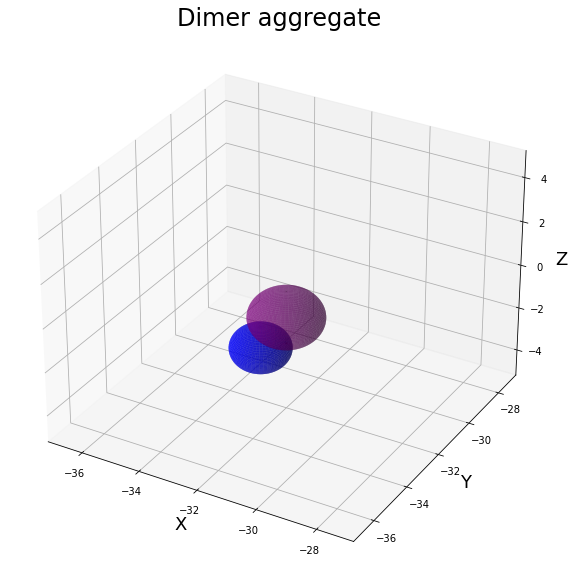

In [28]:
image = rayleighgan_dimer.update().resolve()
positions = image.get_property("position")
radius = image.get_property("radius")
vsize = image.get_property("voxel_size")[0]

plt_sphere(
    positions, 
    radius/vsize,
    ranges = [5, 5, 5], 
    title = 'Dimer aggregate'
    ) 

### 5.2 Aggregate of 5-10 connected spheres.

C:\Users\Fredrik\AppData\Local\Temp\ipykernel_8840\328899102.py:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


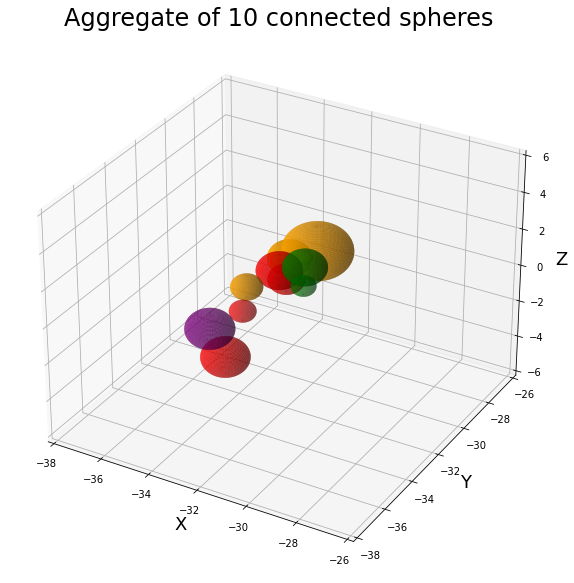

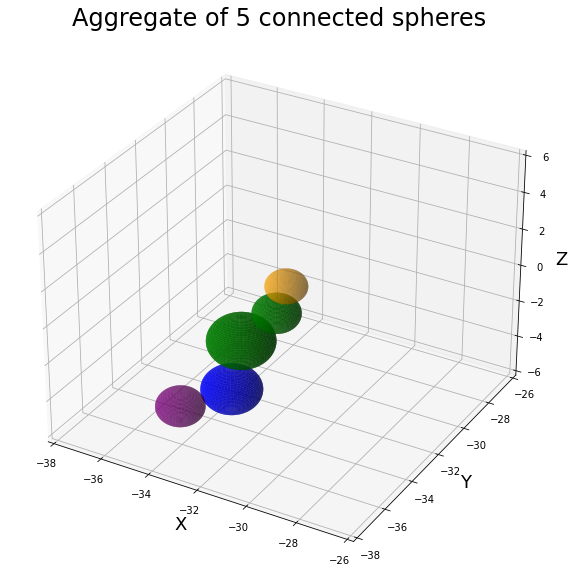

In [29]:
###10 spheres Aggregate
image = rayleighgan_agg10.update().resolve()
positions2 = image.get_property("position")
radius2 = image.get_property("radius")
vsize2 = image.get_property("voxel_size")[0]

plt_sphere(
    positions2, 
    radius2/vsize2,
    ranges = [6, 6, 6], 
    title = 'Aggregate of 10 connected spheres'
    )

###5 spheres Aggregate
image = rayleighgan_agg5.update().resolve()
positions2 = image.get_property("position")
radius2 = image.get_property("radius")
vsize2 = image.get_property("voxel_size")[0]

plt_sphere(
    positions2, 
    radius2/vsize2,
    ranges = [6, 6, 6], 
    title = 'Aggregate of 5 connected spheres'
    ) 

### 5.3 "Aggregate" of 10 randomly placed spheres.

C:\Users\Fredrik\AppData\Local\Temp\ipykernel_8840\328899102.py:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


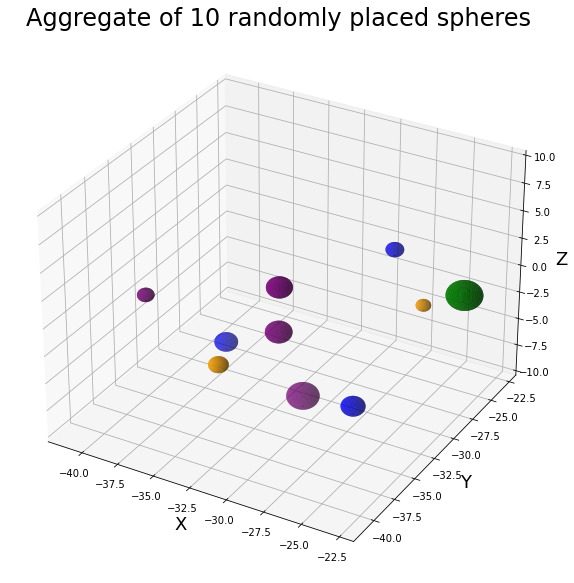

In [30]:
image = rayleighgan_agg10r.update().resolve()
positions3 = image.get_property("position")
radius3 = image.get_property("radius")
vsize3 = image.get_property("voxel_size")[0]

plt_sphere(
    positions3, 
    radius3/vsize3, 
    ranges = [10, 10, 10],
    title = 'Aggregate of 10 randomly placed spheres'
    ) 